<a href="https://colab.research.google.com/github/Dyakonov/Colab/blob/main/dj_word_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ схожести слов

сначала скачаем два датасета

Что интересно:
- L2-расстояние - самый адекватный способ для оценки схожести
- обучить что-то другое не получается (но тут данных мало)
- у w2v скалярное произведение лучше
- BERT-представления что-то не очень (расстояния между ними плохие и при обучении линейной регрессии она дико переобучается по сравнению с другими моделями)


SotA на SemLex: Spearman=0.76 (у меня меньше)
https://aclweb.org/aclwiki/SimLex-999_(State_of_the_art)

In [ ]:
!pip install transformers
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 5.2 MB/s 
     |████████████████████████████████| 163 kB 45.0 MB/s 
     |████████████████████████████████| 7.6 MB 40.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 1.9 MB/s 
     |████████████████████████████████| 1.3 MB 36.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=07a03014b71e7b40ddc0ee99875ee54a1927bca89c3771334907c48d13253309
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [ ]:
import torch

### Загружаем датасеты

In [ ]:
import requests, zipfile, io
r = requests.get("http://www-nlp.stanford.edu/~lmthang/morphoNLM/rw.zip", stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("./tmp/")

# ! ls ./tmp/rw/

import pandas as pd

df_morphoNLM = pd.read_csv('./tmp/rw/rw.txt', sep='\t', header=None)
print (df_morphoNLM.shape)
df_morphoNLM.head()

(2034, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,squishing,squirt,5.88,7,7,6,1,4,6,6,7.0,2.0,4.0
1,undated,undatable,5.83,10,9,6,5,5,7,7,9.0,2.0,5.0
2,circumvents,beat,5.33,7,7,3,9,8,6,3,2.0,0.0,6.0
3,circumvents,ebb,3.25,7,4,6,4,2,0,0,3.0,6.0,0.0
4,dispossess,deprive,6.83,10,6,7,10,10,8,5,8.0,1.0,7.0


In [ ]:
import requests, zipfile, io
#, StringIO
r = requests.get("https://www.cl.cam.ac.uk/~fh295/SimLex-999.zip", stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("./tmp/")

import pandas as pd

df_SimLex = pd.read_csv('./tmp/SimLex-999/SimLex-999.txt', sep='\t')
print (df_SimLex.shape)
df_SimLex.head()

(999, 10)


,word1,word2,POS,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex)
0,old,new,A,1.58,2.72,2.81,2,7.25,1,0.41
1,smart,intelligent,A,9.20,1.75,2.46,1,7.11,1,0.67
2,hard,difficult,A,8.77,3.76,2.21,2,5.94,1,1.19
3,happy,cheerful,A,9.55,2.56,2.34,1,5.85,1,2.18
4,hard,easy,A,0.95,3.76,2.07,2,5.82,1,0.93


# Исследование BERT-представлений

In [ ]:
from transformers import BertModel, BertTokenizer
model_class, tokenizer_class, pretrained_weights = (BertModel, BertTokenizer, 'bert-base-uncased')
# pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def f(x, mode='CLS'):
  if mode == 'CLS':
    inp = torch.tensor(tokenizer.encode(x, add_special_tokens=True)).unsqueeze(0)
  elif mode == 'mean':
    inp = torch.tensor(tokenizer.encode(x, add_special_tokens=False)).unsqueeze(0)
  else:
    inp = None
  att = torch.ones_like(inp) # маска внимания
  out = model(inp, att) # выход модели
  if mode == 'CLS':
    return out[0][:,0,:].squeeze().detach().numpy()
  elif mode == 'mean':
    return out[0].mean(1).squeeze().detach().numpy()
  else:
    return None

In [ ]:
import numpy as np
from tqdm.autonotebook import tqdm

coding_model = f

m1 = df_morphoNLM.shape[0]
print (f'число объектов = {m1}')
n = len(coding_model('example'))
print (f'число признаков = {n}')
X1w1 = np.zeros([m1, n])
X1w2 = np.zeros([m1, n])
y1 = np.zeros(m1)

texts1 = df_morphoNLM[0].values
texts2 = df_morphoNLM[1].values
y1 = df_morphoNLM[2].values

for j in tqdm(range(m1)):
  X1w1[j, :] =  coding_model(texts1[j], mode='mean')
  X1w2[j, :] =  coding_model(texts2[j], mode='mean')

число объектов = 2034
число признаков = 768


  0%|          | 0/2034 [00:00<?, ?it/s]

In [ ]:
import numpy as np
from tqdm.autonotebook import tqdm

coding_model = f

m2 = df_SimLex.shape[0]
print (f'число объектов = {m2}')
n = len(coding_model('example'))
print (f'число признаков = {n}')
X2w1 = np.zeros([m2, n])
X2w2 = np.zeros([m2, n])
y2 = np.zeros(m2)

texts1 = df_SimLex['word1'].values
texts2 = df_SimLex['word2'].values
y2 = df_SimLex['SimLex999'].values

for j in tqdm(range(m2)):
  X2w1[j, :] =  coding_model(texts1[j], mode='mean')
  X2w2[j, :] =  coding_model(texts2[j], mode='mean')

число объектов = 999
число признаков = 768


  0%|          | 0/999 [00:00<?, ?it/s]

In [ ]:
m1 = df_morphoNLM.shape[0]
m2 = df_SimLex.shape[0]

r1 = np.zeros(m1)
r2 = np.zeros(m2)

for j in tqdm(range(m1)):
  r1[j] = np.mean(X1w1[j, :] * X1w2[j, :]) # np.linalg.norm(X1w1[j, :] - X1w2[j, :])

for j in tqdm(range(m2)):
  r2[j] = np.mean(X2w1[j, :] * X2w2[j, :]) # np.linalg.norm(X2w1[j, :] - X2w2[j, :])

  0%|          | 0/2034 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
# import warnings
# warnings.filterwarnings("ignore")
# pd.set_option('display.max_columns', None)
import matplotlib as mpl
plt.rc('font', size=14)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


коэффициент корреляции Пирсона = 0.07088623120525077, Спирмана=0.05462553402574067


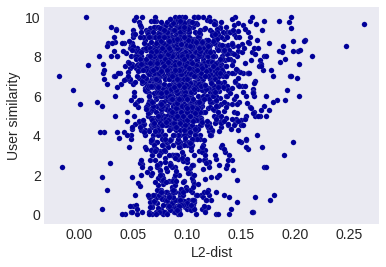

In [ ]:
plt.scatter(r1, y1, 30, c='#000099', edgecolor='w', lw=0.1)
plt.xlabel('L2-dist')
plt.ylabel('User similarity')
print (f'коэффициент корреляции Пирсона = {pd.Series(r1).corr(pd.Series(y1), method="pearson")}, Спирмана={pd.Series(r1).corr(pd.Series(y1), method="spearman")}') # np.corrcoef(r, y)[1,0]
# коэффициент корреляции Пирсона = -0.08391716530488905, Спирмана=-0.07524879372016242
# коэффициент корреляции Пирсона = -0.04160178536109674, Спирмана=-0.05076304137731197

коэффициент корреляции Пирсона = 0.06085105681714389, Спирмана=0.050802910614373524


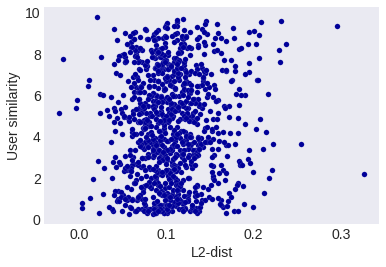

In [ ]:
plt.scatter(r2, y2, 30, c='#000099', edgecolor='w', lw=0.1)
plt.xlabel('L2-dist')
plt.ylabel('User similarity')
print (f'коэффициент корреляции Пирсона = {pd.Series(r2).corr(pd.Series(y2), method="pearson")}, Спирмана={pd.Series(r2).corr(pd.Series(y2), method="spearman")}') # np.corrcoef(r, y)[1,0]

In [ ]:
# f('perfect', mode='CLS')

In [ ]:
f

<function RandomState.f>

# Используем представления из SentenceTransformer - T5 base

это представления предложений, но мы запихнём отдельные слова

In [ ]:
from sentence_transformers import SentenceTransformer

def make_coding_model(model='sbert', mode='paraphrase-MiniLM-L6-v2'):
  """
  кодирующая модель - для получения представлений
  """
  if model == 'sbert':
    print (f'модель: {model}, модификация: {mode}')
    model = SentenceTransformer(mode)
    return model.encode
  print ('Неизвестная модель')
  return NaN

coding_model = make_coding_model(model='sbert', mode='sentence-t5-base') # sentence-t5-base

модель: sbert, модификация: sentence-t5-base


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/115 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/74.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/198 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/219M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/461 [00:00<?, ?B/s]

In [ ]:
import numpy as np
from tqdm.autonotebook import tqdm

m1 = df_morphoNLM.shape[0]
print (f'число объектов = {m1}')
n = len(coding_model('example'))
print (f'число признаков = {n}')
X1w1 = np.zeros([m1, n])
X1w2 = np.zeros([m1, n])
y1 = np.zeros(m1)

texts1 = df_morphoNLM[0].values
texts2 = df_morphoNLM[1].values
y1 = df_morphoNLM[2].values

for j in tqdm(range(m1)):
  X1w1[j, :] =  coding_model(texts1[j])
  X1w2[j, :] =  coding_model(texts2[j])

число объектов = 2034
число признаков = 768


  0%|          | 0/2034 [00:00<?, ?it/s]

In [ ]:
import numpy as np
from tqdm.autonotebook import tqdm

m2 = df_SimLex.shape[0]
print (f'число объектов = {m2}')
n = len(coding_model('example'))
print (f'число признаков = {n}')
X2w1 = np.zeros([m2, n])
X2w2 = np.zeros([m2, n])
y2 = np.zeros(m2)

texts1 = df_SimLex['word1'].values
texts2 = df_SimLex['word2'].values
y2 = df_SimLex['SimLex999'].values

for j in tqdm(range(m2)):
  X2w1[j, :] =  coding_model(texts1[j])
  X2w2[j, :] =  coding_model(texts2[j])

число объектов = 999
число признаков = 768


  0%|          | 0/999 [00:00<?, ?it/s]

In [ ]:
# m1 = df_morphoNLM.shape[0]
# m2 = df_SimLex.shape[0]

#r1 = np.zeros(m1)
r2 = np.zeros(m2)

#for j in tqdm(range(m1)):
#  r1[j] = np.linalg.norm(X1w1[j, :] - X1w2[j, :])

for j in tqdm(range(m2)):
  r2[j] = np.linalg.norm(X2w1[j, :] - X2w2[j, :])

  0%|          | 0/999 [00:00<?, ?it/s]

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
# import warnings
# warnings.filterwarnings("ignore")
# pd.set_option('display.max_columns', None)
import matplotlib as mpl
plt.rc('font', size=14)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


коэффициент корреляции Пирсона = -0.5655104948782828, Спирмана=-0.6062320547280452


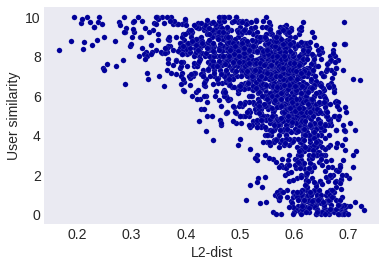

In [ ]:
plt.scatter(r1, y1, 30, c='#000099', edgecolor='w', lw=0.1)
plt.xlabel('L2-dist')
plt.ylabel('User similarity')
print (f'коэффициент корреляции Пирсона = {pd.Series(r1).corr(pd.Series(y1), method="pearson")}, Спирмана={pd.Series(r1).corr(pd.Series(y1), method="spearman")}') # np.corrcoef(r, y)[1,0]

In [ ]:
# y2

коэффициент корреляции Пирсона = -0.6339472716955326, Спирмана=-0.631927016511739


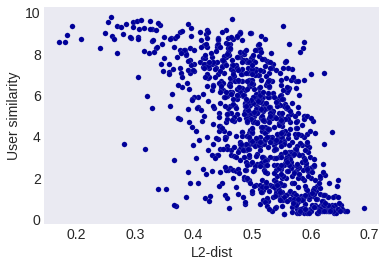

In [ ]:
plt.scatter(r2, y2, 30, c='#000099', edgecolor='w', lw=0.1)
plt.xlabel('L2-dist')
plt.ylabel('User similarity')
print (f'коэффициент корреляции Пирсона = {pd.Series(r2).corr(pd.Series(y2), method="pearson")}, Спирмана={pd.Series(r2).corr(pd.Series(y2), method="spearman")}') # np.corrcoef(r, y)[1,0]

In [ ]:
e = []
for i in range(n):
  e.append(np.corrcoef(np.abs(X1[:,i] - X2[:,i]), y)[1,0])

Text(0, 0.5, 'корреляция по признакам')

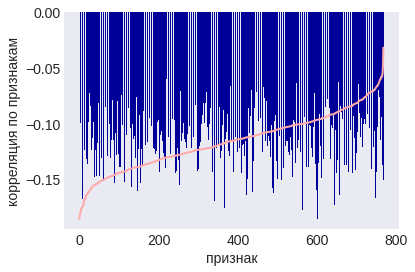

In [ ]:
plt.bar(np.arange(n), e, color='#000099')
plt.plot(np.sort(e), color='#FFAAAA', lw=2)
plt.xlabel('признак')
plt.ylabel('корреляция по признакам')

# w2v

In [ ]:
#import requests, zipfile, io
#r = requests.get("https://www.dropbox.com/s/flh1fjynqvdsj4p/lexvec.commoncrawl.300d.W.pos.vectors.gz?dl=1", stream=True)
#z = zipfile.ZipFile(io.BytesIO(r.content))
#z.extractall("./tmp2/")
!wget https://www.dropbox.com/s/flh1fjynqvdsj4p/lexvec.commoncrawl.300d.W.pos.vectors.gz

--2022-10-20 15:46:48--  https://www.dropbox.com/s/flh1fjynqvdsj4p/lexvec.commoncrawl.300d.W.pos.vectors.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/flh1fjynqvdsj4p/lexvec.commoncrawl.300d.W.pos.vectors.gz [following]
--2022-10-20 15:46:48--  https://www.dropbox.com/s/raw/flh1fjynqvdsj4p/lexvec.commoncrawl.300d.W.pos.vectors.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc70e527339785aed98199dbb94f.dl.dropboxusercontent.com/cd/0/inline/BvIBSmabqHlT7pPPPBB2IDIB33jSB_6rcMt35dxgMQYjqsPlyEXwE5Ktd1ztTyT2W3uVwItuvu2EHlGVX-ys-cTEh-UAMLygK0-bTmAwEyr2WBA4M9ZcwVuRdCYm7qePY9muiPDHll7LXuEj82ljYjCfMln45ZPu9_YopntZXcxsOQ/file# [following]
--2022-10-20 15:46:49--  https://uc70e527339785aed98199dbb94f.dl.dropboxusercontent.com/cd/0/inl

In [ ]:
!gunzip lexvec.commoncrawl.300d.W.pos.vectors.gz

In [ ]:
!ls

 lexvec.commoncrawl.300d.W.pos.vectors		  sample_data
'lexvec.commoncrawl.300d.W.pos.vectors.gz?dl=1'   tmp


In [ ]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('./lexvec.commoncrawl.300d.W.pos.vectors')
# , binary=True

In [ ]:
#from gensim.models import Word2Vec

#word2vec = Word2Vec([list(df_SimLex['word1'].values) + list(df_SimLex['word2'].values)], min_count=1)

In [ ]:
#len(word2vec.wv.vocab) #, len(list(df_SimLex['word1'].values + df_SimLex['word2'].values))

1028

In [ ]:
#v1 = word2vec.wv['one']
model.wv['one'].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


(300,)

In [ ]:
# v1.shape

(100,)

In [ ]:
import numpy as np
from tqdm.autonotebook import tqdm

m2 = df_SimLex.shape[0]
print (f'число объектов = {m2}')
n = 300 ### 100 положил
print (f'число признаков = {n}')
X2w1_v2w = np.zeros([m2, n])
X2w2_v2w = np.zeros([m2, n])
#y2 = np.zeros(m2)

texts1 = df_SimLex['word1'].values
texts2 = df_SimLex['word2'].values
#y2 = df_SimLex['SimLex999'].values

for j in tqdm(range(m2)):
  X2w1_v2w[j, :] =  model.wv[texts1[j]] # word2vec
  X2w2_v2w[j, :] =  model.wv[texts2[j]]

число объектов = 999
число признаков = 300


  0%|          | 0/999 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [ ]:
r2 = np.zeros(m2)

for j in tqdm(range(m2)):
  r2[j] = np.linalg.norm(X2w1_v2w[j, :] - X2w2_v2w[j, :])

  0%|          | 0/999 [00:00<?, ?it/s]

коэффициент корреляции Пирсона = -0.2963517536881857, Спирмана=-0.28558244755222406


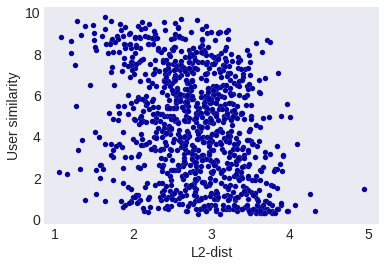

In [ ]:
plt.scatter(r2, y2, 30, c='#000099', edgecolor='w', lw=0.1)
plt.xlabel('L2-dist')
plt.ylabel('User similarity')
print (f'коэффициент корреляции Пирсона = {pd.Series(r2).corr(pd.Series(y2), method="pearson")}, Спирмана={pd.Series(r2).corr(pd.Series(y2), method="spearman")}') # np.corrcoef(r, y)[1,0]

In [ ]:
r2 = np.zeros(m2)

for j in tqdm(range(m2)):
  r2[j] = np.mean(X2w1_v2w[j, :] * X2w2_v2w[j, :])

  0%|          | 0/999 [00:00<?, ?it/s]

коэффициент корреляции Пирсона = 0.4499805985271659, Спирмана=0.46254730655749454


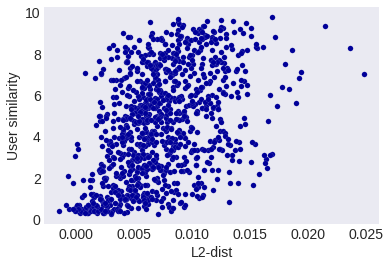

In [ ]:
plt.scatter(r2, y2, 30, c='#000099', edgecolor='w', lw=0.1)
plt.xlabel('L2-dist')
plt.ylabel('User similarity')
print (f'коэффициент корреляции Пирсона = {pd.Series(r2).corr(pd.Series(y2), method="pearson")}, Спирмана={pd.Series(r2).corr(pd.Series(y2), method="spearman")}') # np.corrcoef(r, y)[1,0]

In [ ]:
df_SimLex.sample(5)

,word1,word2,POS,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex)
745,dentist,colonel,N,0.40,4.93,3.89,3,0.00,0,1.70
184,ball,cannon,N,2.58,5.00,4.79,4,1.96,1,1.82
103,dumb,rare,A,0.48,2.36,1.96,1,0.00,0,1.55
798,listen,obey,V,4.93,3.47,2.67,2,1.19,1,1.33
271,phrase,word,N,5.48,2.86,3.56,2,0.74,1,1.73


In [ ]:
model.wv.most_similar(positive=["reject"]) # withdraw

NameError: ignored

In [ ]:
word2vec.wv.most_similar(positive=["phrase"]) # word

[('barn', 0.3803374171257019),
 ('foolish', 0.31202226877212524),
 ('obey', 0.3046574294567108),
 ('anarchy', 0.2683667540550232),
 ('deck', 0.26724177598953247),
 ('profession', 0.25614097714424133),
 ('pact', 0.25113630294799805),
 ('kid', 0.2485707849264145),
 ('pray', 0.24304065108299255),
 ('anatomy', 0.24113178253173828)]

In [ ]:
model

NameError: ignored

# FastText

In [ ]:
from gensim.models import FastText

In [ ]:
FastText()

In [ ]:
import numpy as np
from tqdm.autonotebook import tqdm

m = df.shape[0]
print (f'число объектов = {m}')
n = len(coding_model('example'))
print (f'число признаков = {n}')
X1 = np.zeros([m, n])
X2 = np.zeros([m, n])
y = np.zeros(m)

texts1 = df[0].values
texts2 = df[1].values
y = df[2].values

for j in tqdm(range(m)):
  X1[j, :] =  coding_model('This is ' + texts1[j])
  X2[j, :] =  coding_model('This is ' + texts2[j])

число объектов = 2034
число признаков = 768


  0%|          | 0/2034 [00:00<?, ?it/s]

In [ ]:
r2 = np.zeros(m)

for j in tqdm(range(m)):
  r2[j] = np.linalg.norm(X1[j, :] - X2[j, :])

  0%|          | 0/2034 [00:00<?, ?it/s]

коэффициент корреляции Пирсона = -0.5422766571364246, Спирмана=-0.5793320465174515


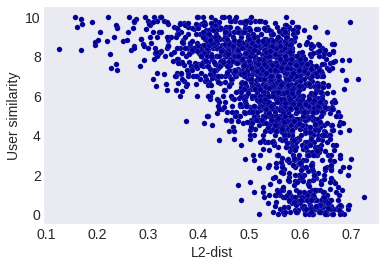

In [ ]:
plt.scatter(r2, y, 30, c='#000099', edgecolor='w', lw=0.1)
plt.xlabel('L2-dist')
plt.ylabel('User similarity')
print (f'коэффициент корреляции Пирсона = {pd.Series(r2).corr(pd.Series(y), method="pearson")}, Спирмана={pd.Series(r2).corr(pd.Series(y), method="spearman")}') # np.corrcoef(r, y)[1,0]

коэффициент корреляции Пирсона = 0.9370381966563717, Спирмана=0.9123669058872961


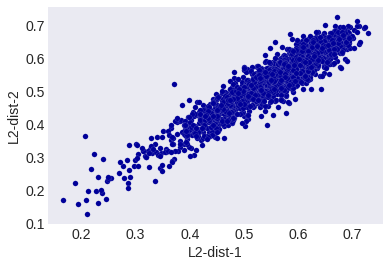

In [ ]:
plt.scatter(r, r2, 30, c='#000099', edgecolor='w', lw=0.1)
plt.xlabel('L2-dist-1')
plt.ylabel('L2-dist-2')
print (f'коэффициент корреляции Пирсона = {pd.Series(r2).corr(pd.Series(r), method="pearson")}, Спирмана={pd.Series(r2).corr(pd.Series(r), method="spearman")}') # np.corrcoef(r, y)[1,0]

In [ ]:
np.nonzero((r<0.22) &( r2 > 0.35))
df.loc[200, :]

0     wealthy
1        rich
2        9.67
3           8
4          10
5          10
6           9
7          10
8           9
9          10
10        9.0
11       10.0
12       10.0
Name: 200, dtype: object

In [ ]:
import numpy as np
from tqdm.autonotebook import tqdm

m = df.shape[0]
print (f'число объектов = {m}')
n = len(coding_model('example'))
print (f'число признаков = {n}')
X1 = np.zeros([m, n])
X2 = np.zeros([m, n])
y = np.zeros(m)

texts1 = df[0].values
texts2 = df[1].values
y = df[2].values

for j in tqdm(range(m)):
  X1[j, :] =  coding_model('I like ' + texts1[j])
  X2[j, :] =  coding_model('I like ' + texts2[j])

число объектов = 2034
число признаков = 768


  0%|          | 0/2034 [00:00<?, ?it/s]

In [ ]:
r3 = np.zeros(m)

for j in tqdm(range(m)):
  r3[j] = np.linalg.norm(X1[j, :] - X2[j, :])

  0%|          | 0/2034 [00:00<?, ?it/s]

коэффициент корреляции Пирсона = -0.564881096117335, Спирмана=-0.6055279186931256


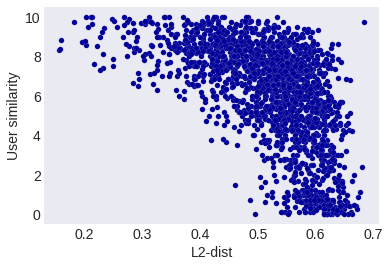

In [ ]:
plt.scatter(r3, y, 30, c='#000099', edgecolor='w', lw=0.1)
plt.xlabel('L2-dist')
plt.ylabel('User similarity')
print (f'коэффициент корреляции Пирсона = {pd.Series(r3).corr(pd.Series(y), method="pearson")}, Спирмана={pd.Series(r3).corr(pd.Series(y), method="spearman")}') # np.corrcoef(r, y)[1,0]

In [ ]:
np.nonzero((y > 8) &( r3 > 0.65))
df.iloc[953, :]

0     evacuated
1         empty
2          9.71
3             7
4             8
5             6
6            10
7            10
8            10
9            10
10         10.0
11          7.0
12         10.0
Name: 953, dtype: object

In [ ]:
import numpy as np
from tqdm.autonotebook import tqdm

m = df.shape[0]
print (f'число объектов = {m}')
n = len(coding_model('example'))
print (f'число признаков = {n}')
X1 = np.zeros([m, n])
X2 = np.zeros([m, n])
y = np.zeros(m)

texts1 = df[0].values
texts2 = df[1].values
y = df[2].values

for j in tqdm(range(m)):
  X1[j, :] =  coding_model((texts1[j] + ', ')*20)
  X2[j, :] =  coding_model((texts2[j] + ', ')*20)

число объектов = 2034
число признаков = 768


  0%|          | 0/2034 [00:00<?, ?it/s]

In [ ]:
r4 = np.zeros(m)

for j in tqdm(range(m)):
  r4[j] = np.linalg.norm(X1[j, :] - X2[j, :])

  0%|          | 0/2034 [00:00<?, ?it/s]

коэффициент корреляции Пирсона = -0.537426569960083, Спирмана=-0.5872420965128472


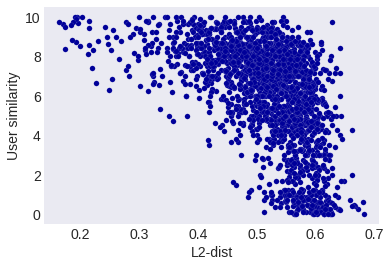

In [ ]:
plt.scatter(r4, y, 30, c='#000099', edgecolor='w', lw=0.1)
plt.xlabel('L2-dist')
plt.ylabel('User similarity')
print (f'коэффициент корреляции Пирсона = {pd.Series(r4).corr(pd.Series(y), method="pearson")}, Спирмана={pd.Series(r4).corr(pd.Series(y), method="spearman")}') # np.corrcoef(r, y)[1,0]

# Попытка формально решить задачу

In [ ]:
X1 = X1w1.copy()
X2 = X1w2.copy()
y = y1.copy()

X1.shape, X2.shape, y.shape

((2034, 768), (2034, 768), (2034,))

In [ ]:
X = np.concatenate([X1, X2], axis=1)
X.shape

(2034, 1536)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=10.0)
model.fit(X_train, y_train)
a_train = model.predict(X_train)
a_test = model.predict(X_test)

обучение: коэффициент корреляции Пирсона = 0.9072645406555324, Спирмана=0.8849127438442527
тест: коэффициент корреляции Пирсона = 0.1645947838740517, Спирмана=0.172808390590696


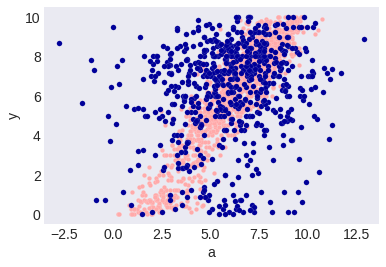

In [ ]:
plt.scatter(a_train, y_train, 20, c='#FFAAAA', edgecolor='w', lw=0.1)
plt.scatter(a_test, y_test, 30, c='#000099', edgecolor='w', lw=0.1)
plt.xlabel('a')
plt.ylabel('y')
print (f'обучение: коэффициент корреляции Пирсона = {pd.Series(a_train).corr(pd.Series(y_train), method="pearson")}, Спирмана={pd.Series(a_train).corr(pd.Series(y_train), method="spearman")}') # np.corrcoef(r, y)[1,0]
print (f'тест: коэффициент корреляции Пирсона = {pd.Series(a_test).corr(pd.Series(y_test), method="pearson")}, Спирмана={pd.Series(a_test).corr(pd.Series(y_test), method="spearman")}') # np.corrcoef(r, y)[1,0]

# от T5 вроде брали
#обучение: коэффициент корреляции Пирсона = 0.464581957947722, Спирмана=0.4909600241449264
#тест: коэффициент корреляции Пирсона = 0.30393797300881664, Спирмана=0.34064619749014435

# BERT
# обучение: коэффициент корреляции Пирсона = 0.9072645406555324, Спирмана=0.8849127438442527
# тест: коэффициент корреляции Пирсона = 0.1645947838740517, Спирмана=0.172808390590696

обучение: коэффициент корреляции Пирсона = 0.7916305946003657, Спирмана=0.7579447292547355
тест: коэффициент корреляции Пирсона = 0.10247351949148448, Спирмана=0.10635865448058032


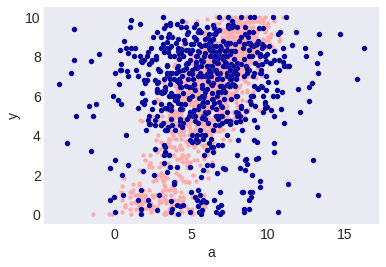

In [ ]:
X = (X1 - X2) ** 2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

from sklearn.linear_model import Ridge
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
a_train = model.predict(X_train)
a_test = model.predict(X_test)

plt.scatter(a_train, y_train, 20, c='#FFAAAA', edgecolor='w', lw=0.1)
plt.scatter(a_test, y_test, 30, c='#000099', edgecolor='w', lw=0.1)
plt.xlabel('a')
plt.ylabel('y')
print (f'обучение: коэффициент корреляции Пирсона = {pd.Series(a_train).corr(pd.Series(y_train), method="pearson")}, Спирмана={pd.Series(a_train).corr(pd.Series(y_train), method="spearman")}') # np.corrcoef(r, y)[1,0]
print (f'тест: коэффициент корреляции Пирсона = {pd.Series(a_test).corr(pd.Series(y_test), method="pearson")}, Спирмана={pd.Series(a_test).corr(pd.Series(y_test), method="spearman")}') # np.corrcoef(r, y)[1,0]

# модуль разности - вроде T5
# обучение: коэффициент корреляции Пирсона = 0.6882843009486982, Спирмана=0.7237126463229472
# тест: коэффициент корреляции Пирсона = 0.5443426710757507, Спирмана=0.5693179225502275
# квадрат разности - вроде T5
# обучение: коэффициент корреляции Пирсона = 0.6237347616183228, Спирмана=0.6403452302443574
# тест: коэффициент корреляции Пирсона = 0.574787484643796, Спирмана=0.5808854338164886

# квадрат разности - BERT
# обучение: коэффициент корреляции Пирсона = 0.7916305946003657, Спирмана=0.7579447292547355
# тест: коэффициент корреляции Пирсона = 0.10247351949148448, Спирмана=0.10635865448058032

In [ ]:
r = - np.sqrt(((X1-X2) ** 2).sum(axis=1))
print (f'коэффициент корреляции Пирсона = {pd.Series(r).corr(pd.Series(y), method="pearson")}, Спирмана={pd.Series(r).corr(pd.Series(y), method="spearman")}') # np.corrcoef(r, y)[1,0]
# T5 коэффициент корреляции Пирсона = 0.5655105018897161, Спирмана=0.6062320547280452

коэффициент корреляции Пирсона = 0.08391716530488905, Спирмана=0.07524879372016242


In [ ]:
r = - (np.abs(X1-X2)).sum(axis=1)
print (f'коэффициент корреляции Пирсона = {pd.Series(r).corr(pd.Series(y), method="pearson")}, Спирмана={pd.Series(r).corr(pd.Series(y), method="spearman")}') # np.corrcoef(r, y)[1,0]
# T5 коэффициент корреляции Пирсона = 0.5664046415390285, Спирмана=0.6060289446936745

коэффициент корреляции Пирсона = 0.08822362914556903, Спирмана=0.07707158584329588


In [ ]:
df[0].values

array(['squishing', 'undated', 'circumvents', ..., 'irredeemable',
       'irredeemable', 'snickering'], dtype=object)

In [ ]:
https://www.cl.cam.ac.uk/~fh295/SimLex-999.zip